In [6]:
import zipfile

with zipfile.ZipFile("data_new.zip", 'r') as zip_ref:
    zip_ref.extractall("data_new_extracted")

In [7]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.images, self.labels = [], []
        self.class_to_idx = {}
        current_label = 0

        for dirpath, dirnames, filenames in os.walk(dataset_dir):
            for dirname in dirnames:
                if dirname not in self.class_to_idx:
                    self.class_to_idx[dirname] = current_label
                    current_label += 1

            for filename in filenames:
                parent_dir = os.path.basename(dirpath)
                if parent_dir in self.class_to_idx:
                    label = self.class_to_idx[parent_dir]
                    img_path = os.path.join(dirpath, filename)
                    self.images.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [9]:
data_dir = '/content/data_new_extracted/data_new'
dataset = ImageDataset(data_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
def average_model_weights(model_paths, model_class):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    models = []

    for path in model_paths:
        model = model_class()
        model.load_state_dict(torch.load(path, map_location=device))
        model = model.to(device)
        models.append(model)

    avg_model = model_class().to(device)
    avg_state_dict = avg_model.state_dict()

    for key in avg_state_dict.keys():
        avg_state_dict[key] = torch.stack([m.state_dict()[key].float() for m in models], 0).mean(0)

    avg_model.load_state_dict(avg_state_dict)
    return avg_model


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from tqdm import tqdm


def train_and_evaluate(model_name, model, dataset, train_transform, val_transform, k_folds=5, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_dir = f"models/{model_name}"
    os.makedirs(model_dir, exist_ok=True)

    train_losses_fold, test_losses_fold = [], []
    train_accs_fold, test_accs_fold = [], []
    aucs_fold = []
    saved_model_paths = []

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
        print(f"Fold {fold+1}/{k_folds} for {model_name}")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_subset.dataset.transform = train_transform
        test_subset.dataset.transform = val_transform

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

        model_fold = model().to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer_fold = optim.Adam(model_fold.parameters(), lr=0.001)
        scheduler_fold = lr_scheduler.StepLR(optimizer_fold, step_size=7, gamma=0.1)

        best_acc = 0.0

        fold_train_losses, fold_test_losses = [], []
        fold_train_accs, fold_test_accs = [], []
        fold_aucs = []

        fpr, tpr, roc_auc = {}, {}, {}

        for epoch in tqdm(range(num_epochs), desc=f"Training {model_name} Fold {fold+1}"):
            model_fold.train()
            running_loss, correct = 0.0, 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer_fold.zero_grad()
                outputs = model_fold(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer_fold.step()

                running_loss += loss.item() * inputs.size(0)
                correct += (outputs.argmax(1) == labels).sum().item()

            train_loss = running_loss / len(train_subset)
            train_acc = correct / len(train_subset)

            fold_train_losses.append(train_loss)
            fold_train_accs.append(train_acc)

            model_fold.eval()
            correct, total, test_loss = 0, 0, 0.0
            all_preds, all_targets = [], []

            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model_fold(inputs)
                    loss = criterion(outputs, labels)

                    test_loss += loss.item() * inputs.size(0)
                    correct += (outputs.argmax(1) == labels).sum().item()
                    total += labels.size(0)

                    all_preds.extend(outputs.softmax(1).cpu().numpy())  # все классы
                    all_targets.extend(labels.cpu().numpy())

            test_loss = test_loss / total
            test_acc = correct / total

            # One-vs-Rest ROC-AUC
            n_classes = outputs.shape[1]
            targets_bin = label_binarize(all_targets, classes=list(range(n_classes)))
            preds_np = np.array(all_preds)

            fpr = dict()
            tpr = dict()
            roc_auc = dict()

            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(targets_bin[:, i], preds_np[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            
            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(n_classes):
                mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            mean_tpr /= n_classes
            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr
            roc_auc["macro"] = auc(all_fpr, mean_tpr)

            
            fpr["micro"], tpr["micro"], _ = roc_curve(targets_bin.ravel(), preds_np.ravel())
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

            fold_test_losses.append(test_loss)
            fold_test_accs.append(test_acc)
            fold_aucs.append(roc_auc["macro"]) 

            if test_acc > best_acc:
                best_acc = test_acc
                save_path = f"{model_dir}/best_model_fold_{fold}.pth"
                torch.save(model_fold.state_dict(), save_path)

        train_losses_fold.append(fold_train_losses)
        test_losses_fold.append(fold_test_losses)
        train_accs_fold.append(fold_train_accs)
        test_accs_fold.append(fold_test_accs)
        aucs_fold.append(fold_aucs)

        saved_model_paths.append(f"{model_dir}/best_model_fold_{fold}.pth")

    averaged_model = average_model_weights(saved_model_paths, model)
    torch.save(averaged_model.state_dict(), f"{model_dir}/averaged_model.pth")

    roc_data = {
        "fpr": fpr,
        "tpr": tpr,
        "roc_auc": roc_auc
    }

    return {
        "train_losses": np.array(train_losses_fold),
        "test_losses": np.array(test_losses_fold),
        "train_accs": np.array(train_accs_fold),
        "test_accs": np.array(test_accs_fold),
        "aucs": np.array(aucs_fold),
        "roc": roc_data
    }


In [55]:
from torchvision import models

model_vit = models.vit_b_16(weights='IMAGENET1K_V1')

In [23]:
model_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [26]:
model_vit.heads.head

Linear(in_features=768, out_features=1000, bias=True)

In [56]:
num_classes = len(dataset.class_to_idx)

In [57]:
model_vit.heads.head = torch.nn.Linear(in_features=768, out_features=num_classes)

In [92]:
def modify_vit(num_classes):
    model = models.vit_b_16(weights='IMAGENET1K_V1')
    model.heads.head = torch.nn.Linear(in_features=768, out_features=num_classes)
    return model


In [96]:
results_vit = train_and_evaluate(
    model_name='VisionTransformer',
    model=lambda: modify_vit(num_classes),
    dataset=dataset,
    train_transform=train_transform,
    val_transform=val_transform,
    num_epochs=30
)

Fold 1/5 for VisionTransformer


Training VisionTransformer Fold 1: 100%|██████████| 30/30 [24:29<00:00, 48.97s/it]


Fold 2/5 for VisionTransformer


Training VisionTransformer Fold 2: 100%|██████████| 30/30 [24:38<00:00, 49.28s/it]


Fold 3/5 for VisionTransformer


Training VisionTransformer Fold 3: 100%|██████████| 30/30 [24:33<00:00, 49.11s/it]


Fold 4/5 for VisionTransformer


Training VisionTransformer Fold 4: 100%|██████████| 30/30 [24:33<00:00, 49.11s/it]


Fold 5/5 for VisionTransformer


Training VisionTransformer Fold 5: 100%|██████████| 30/30 [24:29<00:00, 48.98s/it]


In [59]:
model_shufflenet = models.shufflenet_v2_x1_0(weights='IMAGENET1K_V1')

In [60]:
model_shufflenet

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [61]:
def modify_shufflenet(num_classes):
    model = models.shufflenet_v2_x1_0(weights='IMAGENET1K_V1')
    model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes)
    return model

In [70]:
results_shufflenet = train_and_evaluate(
    model_name='ShuffleNetV2',
    model=lambda: modify_shufflenet(num_classes),
    dataset=dataset,
    train_transform=train_transform,
    val_transform=val_transform,
    num_epochs=20
)

Fold 1/5 for ShuffleNetV2


Training ShuffleNetV2 Fold 1: 100%|██████████| 20/20 [13:03<00:00, 39.19s/it]


Fold 2/5 for ShuffleNetV2


Training ShuffleNetV2 Fold 2: 100%|██████████| 20/20 [13:06<00:00, 39.34s/it]


Fold 3/5 for ShuffleNetV2


Training ShuffleNetV2 Fold 3: 100%|██████████| 20/20 [12:56<00:00, 38.80s/it]


Fold 4/5 for ShuffleNetV2


Training ShuffleNetV2 Fold 4: 100%|██████████| 20/20 [12:52<00:00, 38.62s/it]


Fold 5/5 for ShuffleNetV2


Training ShuffleNetV2 Fold 5: 100%|██████████| 20/20 [12:53<00:00, 38.67s/it]


In [73]:
def modify_mobilenet_v2(num_classes):
    model = models.mobilenet_v2(weights='IMAGENET1K_V2')
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
    return model


In [90]:
results_mobilenetv2 = train_and_evaluate(
    model_name='MobileNetV2',
    model=lambda: modify_mobilenet_v2(num_classes),
    dataset=dataset,
    train_transform=train_transform,
    val_transform=val_transform,
    num_epochs=30
)

Fold 1/5 for MobileNetV2


Training MobileNetV2 Fold 1: 100%|██████████| 30/30 [20:27<00:00, 40.91s/it]


Fold 2/5 for MobileNetV2


Training MobileNetV2 Fold 2: 100%|██████████| 30/30 [20:38<00:00, 41.30s/it]


Fold 3/5 for MobileNetV2


Training MobileNetV2 Fold 3: 100%|██████████| 30/30 [20:36<00:00, 41.23s/it]


Fold 4/5 for MobileNetV2


Training MobileNetV2 Fold 4: 100%|██████████| 30/30 [20:41<00:00, 41.39s/it]


Fold 5/5 for MobileNetV2


Training MobileNetV2 Fold 5: 100%|██████████| 30/30 [20:25<00:00, 40.84s/it]


In [78]:
def modify_mobilenet_v3(num_classes):
    model = models.mobilenet_v3_large(weights='IMAGENET1K_V2')
    model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, num_classes)
    return model

In [79]:
results_mobilenetv3 = train_and_evaluate(
    model_name='MobileNetV3',
    model=lambda: modify_mobilenet_v3(num_classes),
    dataset=dataset,
    train_transform=train_transform,
    val_transform=val_transform,
    num_epochs=20
)

Fold 1/5 for MobileNetV3


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 103MB/s]
Training MobileNetV3 Fold 1: 100%|██████████| 20/20 [13:06<00:00, 39.33s/it]


Fold 2/5 for MobileNetV3


Training MobileNetV3 Fold 2: 100%|██████████| 20/20 [13:27<00:00, 40.35s/it]


Fold 3/5 for MobileNetV3


Training MobileNetV3 Fold 3: 100%|██████████| 20/20 [13:33<00:00, 40.69s/it]


Fold 4/5 for MobileNetV3


Training MobileNetV3 Fold 4: 100%|██████████| 20/20 [13:43<00:00, 41.19s/it]


Fold 5/5 for MobileNetV3


Training MobileNetV3 Fold 5: 100%|██████████| 20/20 [13:31<00:00, 40.56s/it]


In [75]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_metrics(results_dict, model_name):
    epochs = np.arange(results_dict['train_losses'].shape[1])

    fig, ax1 = plt.subplots(figsize=(10, 6))

    train_loss_mean = results_dict['train_losses'].mean(axis=0)
    train_loss_std = results_dict['train_losses'].std(axis=0)
    test_loss_mean = results_dict['test_losses'].mean(axis=0)
    test_loss_std = results_dict['test_losses'].std(axis=0)

    ax1.errorbar(epochs, train_loss_mean, yerr=train_loss_std, fmt='-o', capsize=5, label='Train Loss')
    ax1.errorbar(epochs, test_loss_mean, yerr=test_loss_std, fmt='-s', capsize=5, label='Test Loss')

    ax1.plot(epochs[-1], test_loss_mean[-1], 'ro', label='Final Test Loss', markersize=8)
    ax1.axvline(x=epochs[-1], color='red', linestyle='--', alpha=0.5)

    ax1.set_title(f"{model_name} - Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)
    plt.show()

    fig, ax2 = plt.subplots(figsize=(10, 6))

    train_acc_mean = results_dict['train_accs'].mean(axis=0)
    train_acc_std = results_dict['train_accs'].std(axis=0)
    test_acc_mean = results_dict['test_accs'].mean(axis=0)
    test_acc_std = results_dict['test_accs'].std(axis=0)

    ax2.errorbar(epochs, train_acc_mean, yerr=train_acc_std, fmt='-o', capsize=5, label='Train Accuracy')
    ax2.errorbar(epochs, test_acc_mean, yerr=test_acc_std, fmt='-s', capsize=5, label='Test Accuracy')

    ax2.plot(epochs[-1], test_acc_mean[-1], 'ro', label='Final Test Accuracy', markersize=8)
    ax2.axvline(x=epochs[-1], color='red', linestyle='--', alpha=0.5)

    ax2.set_title(f"{model_name} - Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True)
    plt.show()


In [81]:
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

def plot_multiclass_roc(roc_data, model_name, class_names=None):
    fpr = roc_data["fpr"]
    tpr = roc_data["tpr"]
    roc_auc = roc_data["roc_auc"]
    n_classes = len([k for k in roc_auc.keys() if isinstance(k, int)])

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "purple", "gray", "brown", "olive"])

    plt.figure(figsize=(10, 6))

    for i, color in zip(range(n_classes), colors):
        label_name = class_names[i] if class_names else f"Class {i}"
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f"{label_name} (AUC = {roc_auc[i]:.2f})")

    plt.plot(fpr["macro"], tpr["macro"],
             label=f"Macro-average (AUC = {roc_auc['macro']:.2f})",
             color='navy', linestyle=':', linewidth=2)

    plt.plot(fpr["micro"], tpr["micro"],
             label=f"Micro-average (AUC = {roc_auc['micro']:.2f})",
             color='deeppink', linestyle=':', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


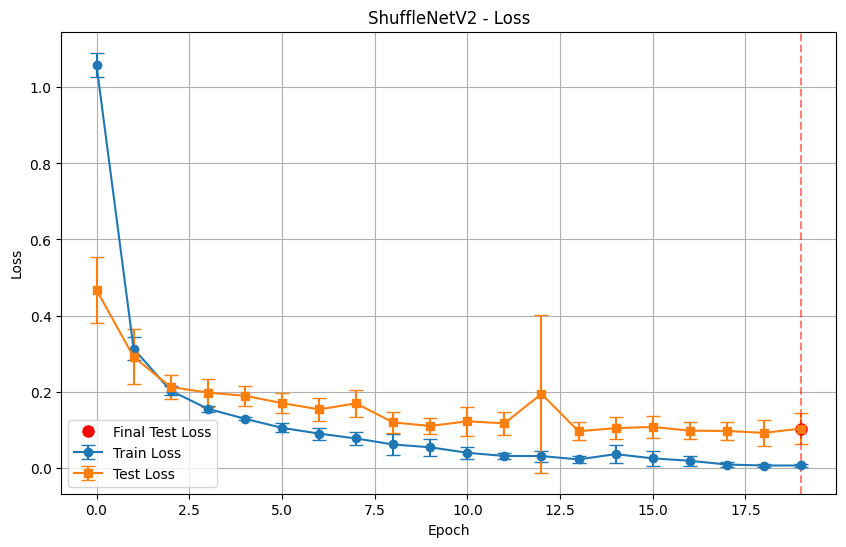

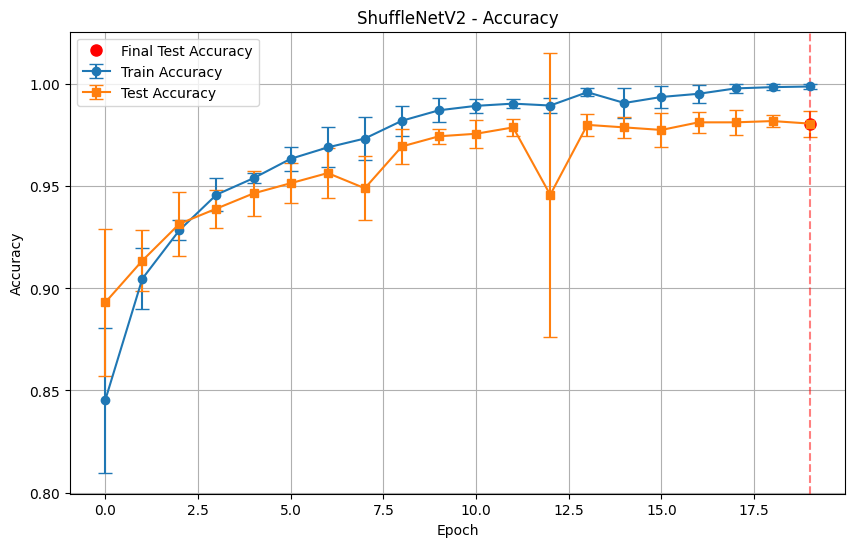

In [72]:
plot_model_metrics(results_shufflenet, "ShuffleNetV2")

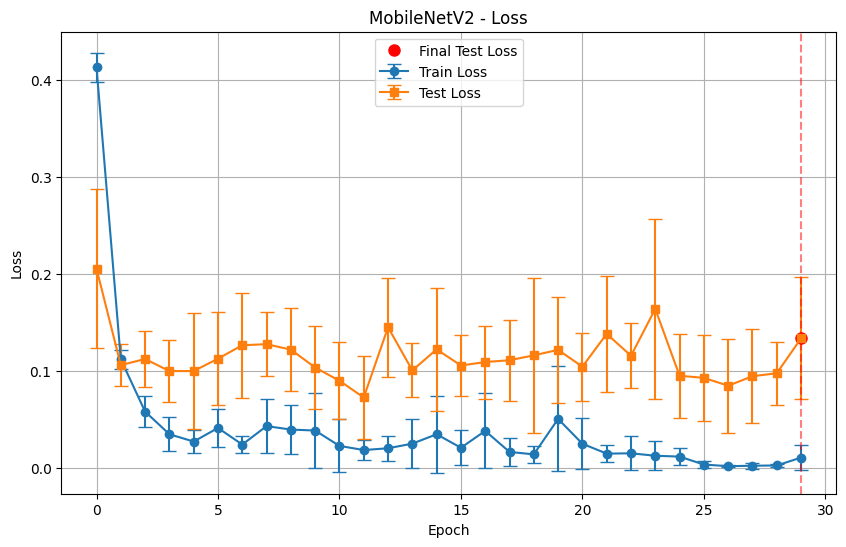

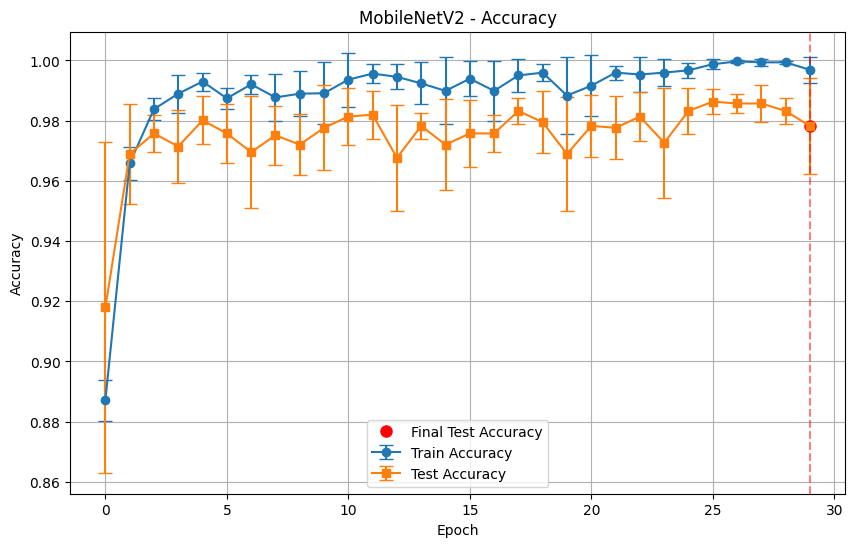

In [91]:
plot_model_metrics(results_mobilenetv2, "MobileNetV2")

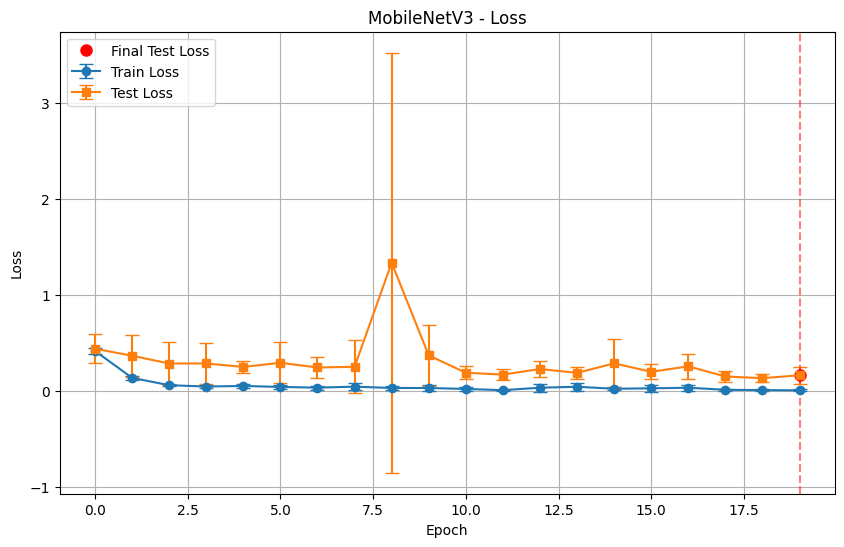

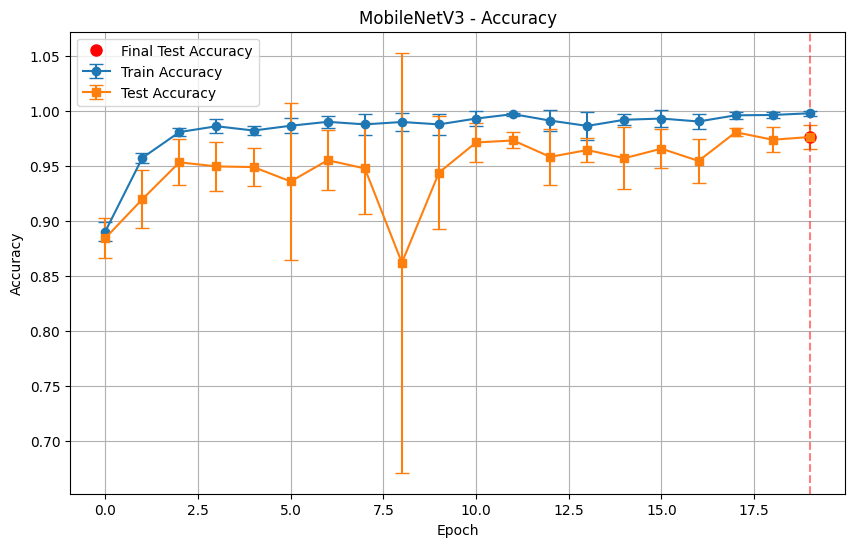

In [80]:
plot_model_metrics(results_mobilenetv3, "MobileNetV3")

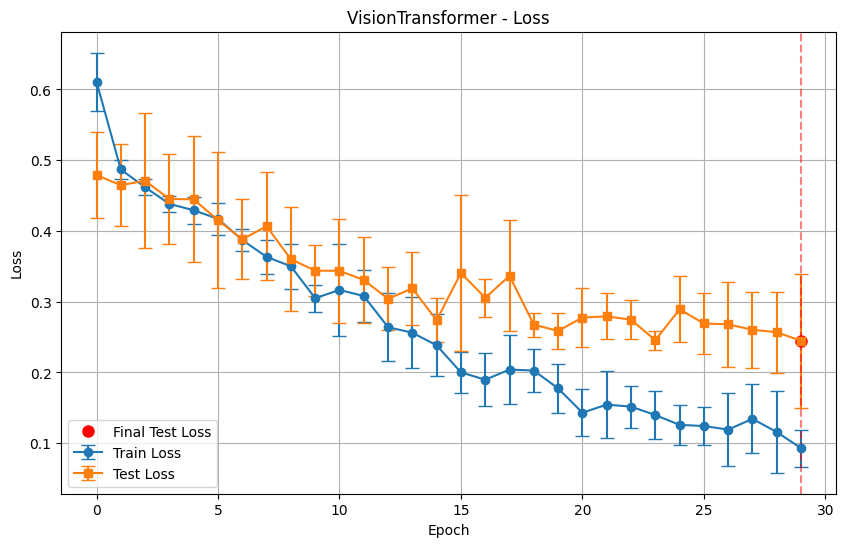

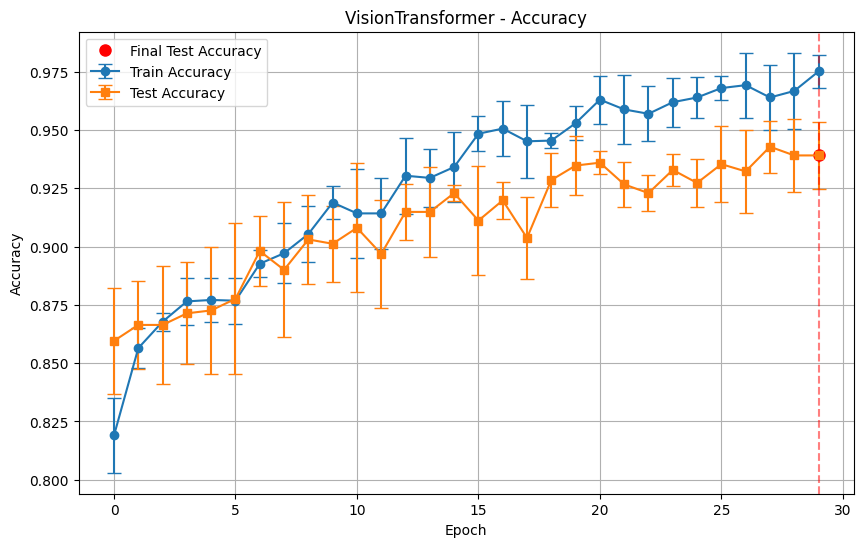

In [97]:
plot_model_metrics(results_vit, "VisionTransformer")

In [85]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]


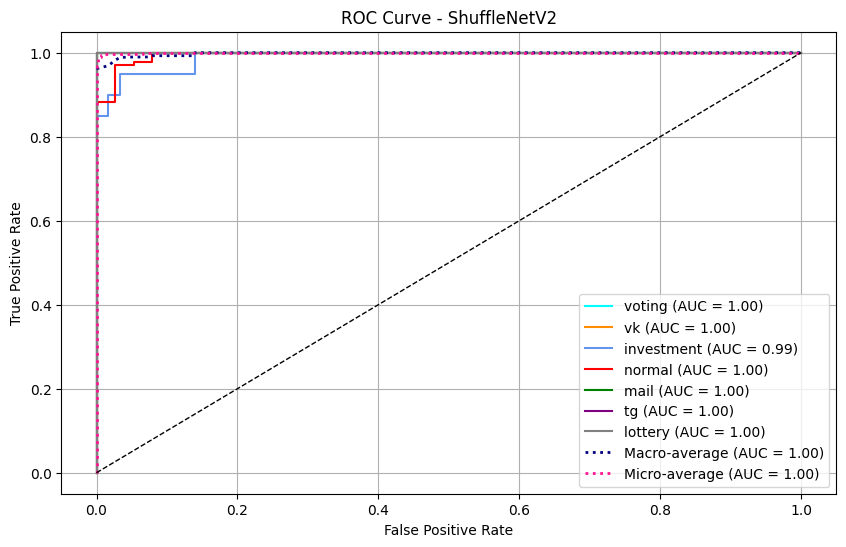

In [88]:
plot_multiclass_roc(results_shufflenet["roc"], "ShuffleNetV2", class_names)

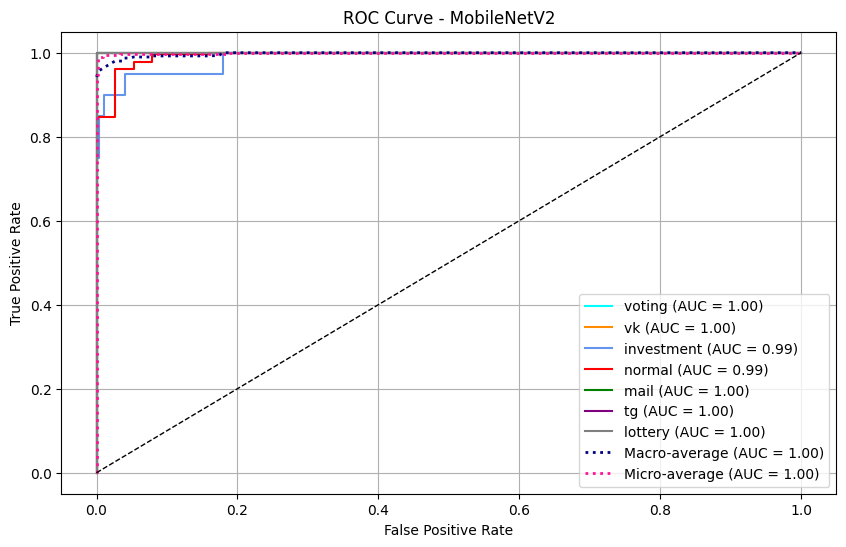

In [86]:
plot_multiclass_roc(results_mobilenetv2["roc"], "MobileNetV2", class_names)

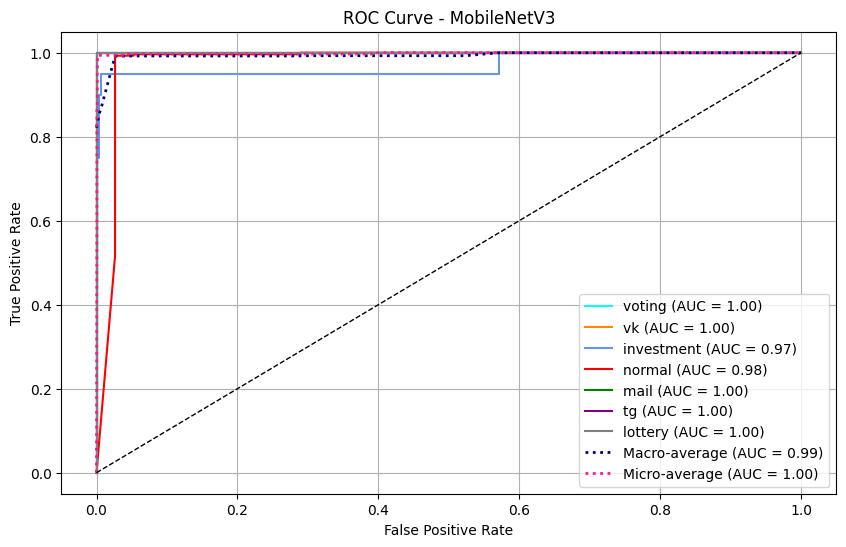

In [87]:
plot_multiclass_roc(results_mobilenetv3["roc"], "MobileNetV3", class_names)

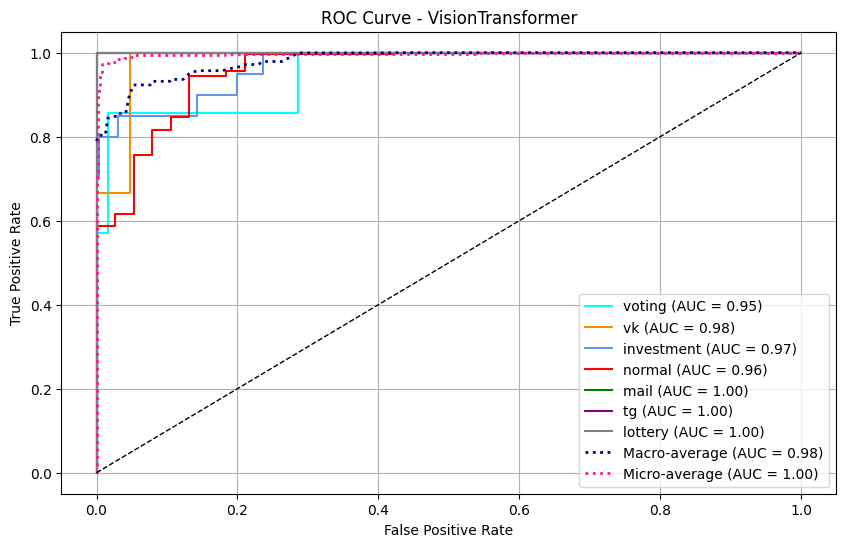

In [98]:
plot_multiclass_roc(results_vit["roc"], "VisionTransformer", class_names)